## Importing necessary Libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [30]:
# now I have to see the dataset
multi_data = pd.read_parquet("multisim_dataset.parquet")

# the first row of it
multi_data.head()

,telephone_number,trf,age,gndr,tenure,age_dev,dev_man,device_os_name,dev_num,is_dualsim,...,val13_6,val14_6,val15_6,val16_6,val17_6,val18_6,val19_6,val20_6,val21_6,target
9626,iWBn_13aJO,J,50,M,6957.0,1263,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.56,0.00,0.00,60.0,7.0,0.0,1
34347,8JWaD2wYoQ,M,52,M,1041.0,125,Samsung,Android OS,2,1,...,206.536585,0.0,0.40,0.00,0.16,0.24,156.0,0.0,2.0,1
72797,sbPnQURi3j,A,49,U,7176.0,345,Samsung,Android OS,1,1,...,0.000000,0.0,0.25,2.35,0.00,0.25,241.0,87.0,4.0,1
68025,qOy-JlqPTl,M,49,M,4309.0,466,Samsung,Android OS,1,1,...,51.885746,0.0,0.00,0.00,0.00,0.00,299.0,142.0,80.0,1
31781,MNODhcb7h0,A,50,U,6999.0,695,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.80,0.00,0.00,121.0,96.0,0.0,1


In [31]:
# checking of the infor and how many are 0
multi_data.info()
multi_data.describe()
multi_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9626 to 90423
Columns: 132 entries, telephone_number to target
dtypes: float64(111), int64(8), object(13)
memory usage: 10.1+ MB


,0
telephone_number,0
trf,0
age,24
gndr,0
tenure,26
...,...
val18_6,272
val19_6,272
val20_6,272
val21_6,272


## Missing values check

In [32]:
# missing values check
na_counts = multi_data.isna().sum().sort_values(ascending=False)
print("Missing values:\n", na_counts)

Missing values:
 simcard_type    349
val6_6          272
val20_6         272
val21_6         272
val19_6         272
               ... 
val3_1            0
val4_1            0
val5_1            0
val2_1            0
target            0
Length: 132, dtype: int64


## Division on categorical and numerical values

In [33]:
categorical_cols = multi_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = multi_data.select_dtypes(exclude=['object']).columns.tolist()

# here we have to ensure that the target is not included as feature so we have to remove it from column
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)

Categorical: ['telephone_number', 'trf', 'age', 'gndr', 'age_dev', 'dev_man', 'device_os_name', 'dev_num', 'is_dualsim', 'is_featurephone', 'is_smartphone', 'simcard_type', 'region']
Numerical: ['tenure', 'val2_1', 'val3_1', 'val4_1', 'val5_1', 'val6_1', 'val7_1', 'val8_1', 'val9_1', 'val10_1', 'val11_1', 'val12_1', 'val13_1', 'val14_1', 'val15_1', 'val16_1', 'val17_1', 'val18_1', 'val19_1', 'val20_1', 'val21_1', 'val2_2', 'val3_2', 'val4_2', 'val5_2', 'val6_2', 'val7_2', 'val8_2', 'val9_2', 'val10_2', 'val11_2', 'val12_2', 'val13_2', 'val14_2', 'val15_2', 'val16_2', 'val17_2', 'val18_2', 'val19_2', 'val20_2', 'val21_2', 'val2_3', 'val3_3', 'val4_3', 'val5_3', 'val6_3', 'val7_3', 'val8_3', 'val9_3', 'val10_3', 'val11_3', 'val12_3', 'val13_3', 'val14_3', 'val15_3', 'val16_3', 'val17_3', 'val18_3', 'val19_3', 'val20_3', 'val21_3', 'val2_4', 'val4_4', 'val5_4', 'val6_4', 'val7_4', 'val8_4', 'val9_4', 'val10_4', 'val11_4', 'val12_4', 'val13_4', 'val14_4', 'val15_4', 'val16_4', 'val17_4', '

## Preprocessing with handling of missing values and encoding

In [34]:
categorical_transformer = Pipeline(steps=[ # with most_frequent + one-hot
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[ # numerical in the median way
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer( # combination of both to see the result
    transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)]
)

## Train Test split

In [35]:
X = multi_data.drop(columns=['target']) # as we wrote previously we have to change the target from x to y column
y = multi_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Creation of the Pipeline with the XGBoost

In [36]:
xgb_multi = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=1.0
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_multi)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Baseline Accuracy: 0.361
Baseline ROC AUC: nan
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.36      2000
   macro avg       0.50      0.18      0.27      2000
weighted avg       1.00      0.36      0.53      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zer

## Hyperparameter Tuning

In [37]:
param_distributions = { # I first used the normal version but I saw rhat it is running too long so I had to use RandomizedSearchCV
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.1, 0.05, 0.03],
    'classifier__n_estimators': [200, 300, 500],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0.0, 0.5, 1.0],
    'classifier__reg_lambda': [1.0, 5.0, 10.0]
}

pipeline.set_params(classifier__tree_method='hist',
                    classifier__n_jobs=-1,
                    classifier__verbosity=1)

rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=6, # I had to reduce this and below parameters
    cv=2,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand.fit(X_train, y_train)

print("Best params:", rand.best_params_)
best_model = rand.best_estimator_

y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned ROC AUC:", roc_auc_score(y_test, y_prob_best))
print(classification_report(y_test, y_pred_best))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best params: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 10.0, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 5, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.03, 'classifier__gamma': 1.0, 'classifier__colsample_bytree': 0.8}
Tuned Accuracy: 0.312
Tuned ROC AUC: nan
              precision    recall  f1-score   support

           0       1.00      0.31      0.48      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.31      2000
   macro avg       0.50      0.16      0.24      2000
weighted avg       1.00      0.31      0.48      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zer

## ROC Curve

Validation ROC AUC: 0.6813


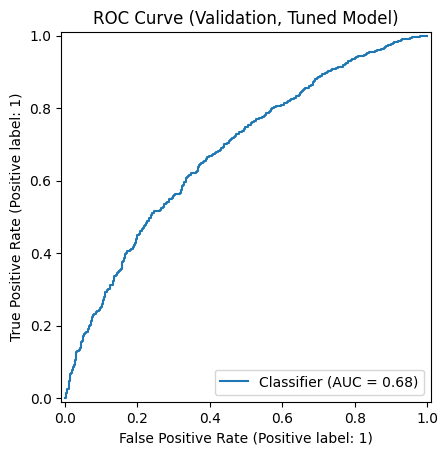

In [43]:
# Small validation set with both classes
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Evaluation of ROC on validation
best_model.fit(X_tr, y_tr)
val_prob = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_prob)
print(f"Validation ROC AUC: {val_auc:.4f}")

RocCurveDisplay.from_predictions(y_val.astype(int), val_prob, pos_label=1)
plt.title("ROC Curve (Validation, Tuned Model)")
plt.show()

## Confusion Matrix

Test Accuracy: 0.312
              precision    recall  f1-score   support

           0       1.00      0.31      0.48      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.31      2000
   macro avg       0.50      0.16      0.24      2000
weighted avg       1.00      0.31      0.48      2000



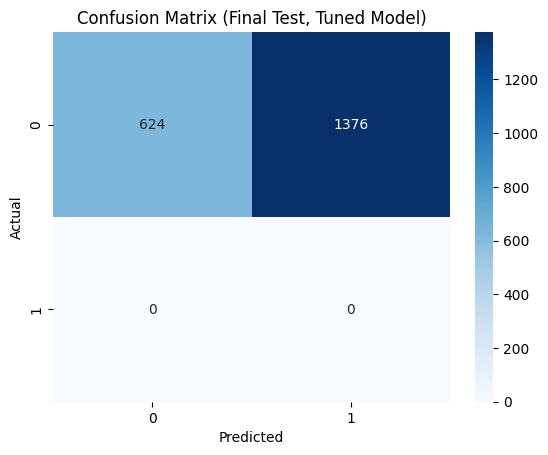

In [44]:
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, zero_division=0))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix (Final Test, Tuned Model)")
plt.show()

## Feature Importances

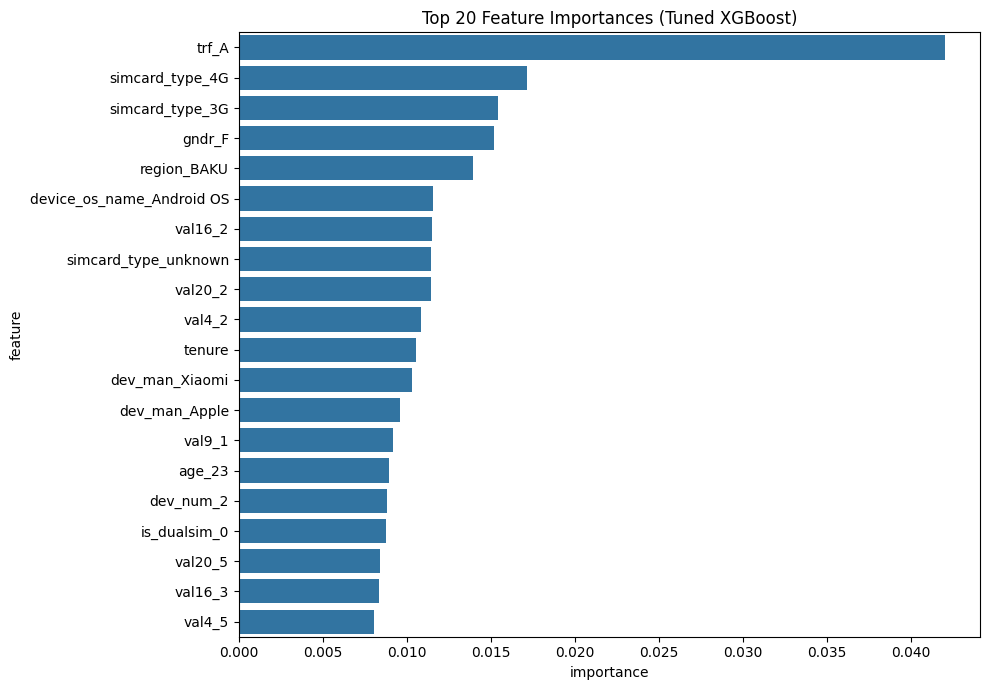

,feature,importance
8115,trf_A,0.042032
10212,simcard_type_4G,0.017138
10211,simcard_type_3G,0.015428
8214,gndr_F,0.015179
10222,region_BAKU,0.013961
10170,device_os_name_Android OS,0.011561
35,val16_2,0.011534
10213,simcard_type_unknown,0.011469
39,val20_2,0.011448
23,val4_2,0.010836


In [45]:
final_xgb = best_model.named_steps['classifier']
importances = final_xgb.feature_importances_

# here we will be having feature names after the preprocessing step
oh = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
oh_features = oh.get_feature_names_out(categorical_cols).tolist()
feature_names = numerical_cols + oh_features

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(data=feat_imp, x='importance', y='feature')
plt.title("Top 20 Feature Importances (Tuned XGBoost)")
plt.tight_layout()
plt.show()

feat_imp

## Visualization

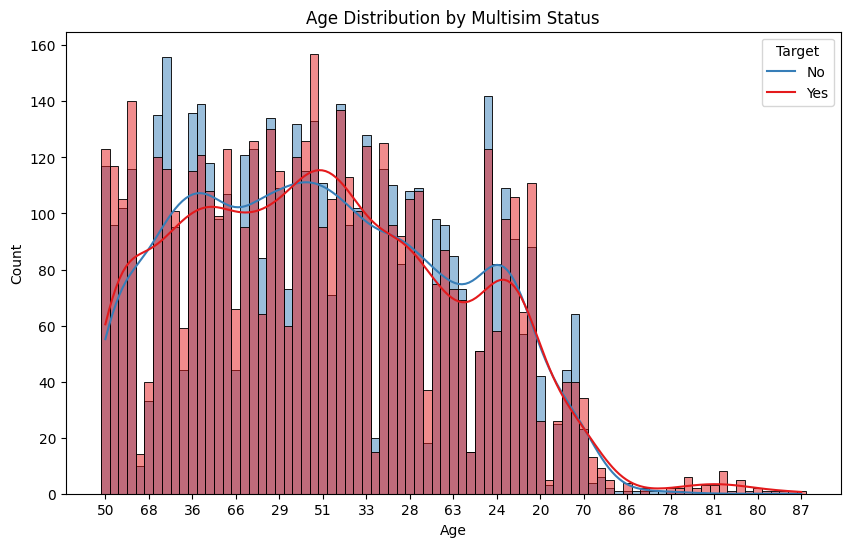

In [46]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10,6))
sns.histplot(
    data=multi_data,
    x='age',
    hue='target',
    kde=True,
    bins=30,
    palette='Set1'
)
plt.title("Age Distribution by Multisim Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Target", labels=["No", "Yes"])

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.show()